In [2]:
import waipy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta # 

import os
os.getcwd()

%cd /g/data/p66/ars599/work_rp2/

/g/data/p66/ars599/work_rp2


In [ ]:
# read netcdf file
#idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p2f1/Amon/ts/gn/v20230426/"
#idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r6i1p1f1/Amon/ts/gn/v20220819/"
#ds = xr.open_dataset(idir+'ts_Amon_ACCESS-CM2_historical_r1i1p2f1_gn_185001-187912.nc')
#ds = xr.open_dataset(idir+'ts_Amon_ACCESS-CM2_historical_r6i1p1f1_gn_185001-194912.nc')

idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p2f1/Amon/ts/gn/v20230604/"
ds = xr.open_dataset(idir+"ts_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc")

# select NINO3 region
ds_nino3 = ds.sel(lon=slice(210, 270), lat=slice(-5, 5))

# Calculate the Nino3 index
n3 = ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])
# Calculate time in fraction of years
n3_time_frac = (n3.time.dt.year + (n3.time.dt.month - 1)/12).values
# Calculate climatology of SST over Nino3 region
sst_climatology = ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month').mean(dim='time')
# Compute anomaly
sst_anomaly = ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month') - sst_climatology
# Calculate the Nino3 anomaly index
n3_anomaly = sst_anomaly.mean(dim=['lon', 'lat']) # .mean('month')
n3_anomaly.to_netcdf('/g/data/p66/ars599/work_rp2/n3_index_ctrl.nc')

# plot NINO3 index against time
fig, ax = plt.subplots()
plt.plot(n3_time_frac, n3_anomaly)
ax.set_xlabel('Time (years)')
ax.set_ylabel('NINO3 index')
plt.show()

In [2]:
""" OPEN ARCHIVE .TXT/.DAT
    archive = file.txt
    dt      = data sampling
    date1   = data initial time"
    https://github.com/chris-torrence/wavelets/tree/main/wave_idl
"""
N =len(n3_anomaly)      # the time series of length N.

dt = 1/12    # amount of time between each time series value, i.e. the sampling time.
            # seasonal data 1/4 year - 4 measures in 1 year

T1 = 1850.  # start time

n3_anomaly[np.isnan(n3_anomaly)] = 0  # replace nan to zero
data_norm = waipy.normalize(n3_anomaly).values

In [3]:
pad = 1         # pad the time series with zeroes (recommended)
dj = 1/12.       # this will do 4 sub-octaves per octave
s0 = 2*dt       # this says start at a scale of 6 months if dt =annual
j1 = 7/dj       # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72     # lag-1 autocorrelation for red noise background
param = 6
mother = 'Morlet'
dt = 1/12.

result = waipy.cwt(data_norm, dt, pad, dj, s0, j1, lag1, param, mother='Morlet',name='Nino3')

Nr of Scales: 110
scales [0.16666666666666666, 0.17657718239321588, 0.18707700805156216, 0.19820118583378682, 0.20998684164914552, 0.22247330902833906, 0.23570226039551584, 0.2497178461461136, 0.2645668419946999, 0.2802988050845715, 0.2969662393801131, 0.3146247708938978, 0.3333333333333333, 0.35315436478643175, 0.37415401610312427, 0.39640237166757364, 0.41997368329829105, 0.444946618056678, 0.4714045207910317, 0.4994356922922272, 0.5291336839893998, 0.560597610169143, 0.5939324787602261, 0.6292495417877956, 0.6666666666666666, 0.7063087295728634, 0.7483080322062485, 0.7928047433351473, 0.839947366596582, 0.889893236113356, 0.9428090415820634, 0.9988713845844541, 1.0582673679787995, 1.121195220338286, 1.187864957520452, 1.2584990835755911, 1.3333333333333333, 1.4126174591457268, 1.496616064412497, 1.5856094866702946, 1.679894733193164, 1.779786472226712, 1.8856180831641267, 1.9977427691689083, 2.116534735957599, 2.242390440676572, 2.375729915040904, 2.5169981671511823, 2.6666666666666

{'fig': <Figure size 4500x3000 with 5 Axes>,
 'ax_data': <AxesSubplot:title={'center':'NINO3 Sea Surface Temperature (CTRL) v2'}, ylabel='Amplitude'>,
 'ax_cwt': <AxesSubplot:xlabel='Time', ylabel='Period'>,
 'ax_wavelet': <AxesSubplot:title={'center':'$\\psi$ (t/s) Morlet in time domain'}, xlabel='Time', ylabel='Amplitude'>,
 'ax_global_spectrum': <AxesSubplot:title={'center':'Global Wavelet Spectrum'}, xlabel='Power'>}

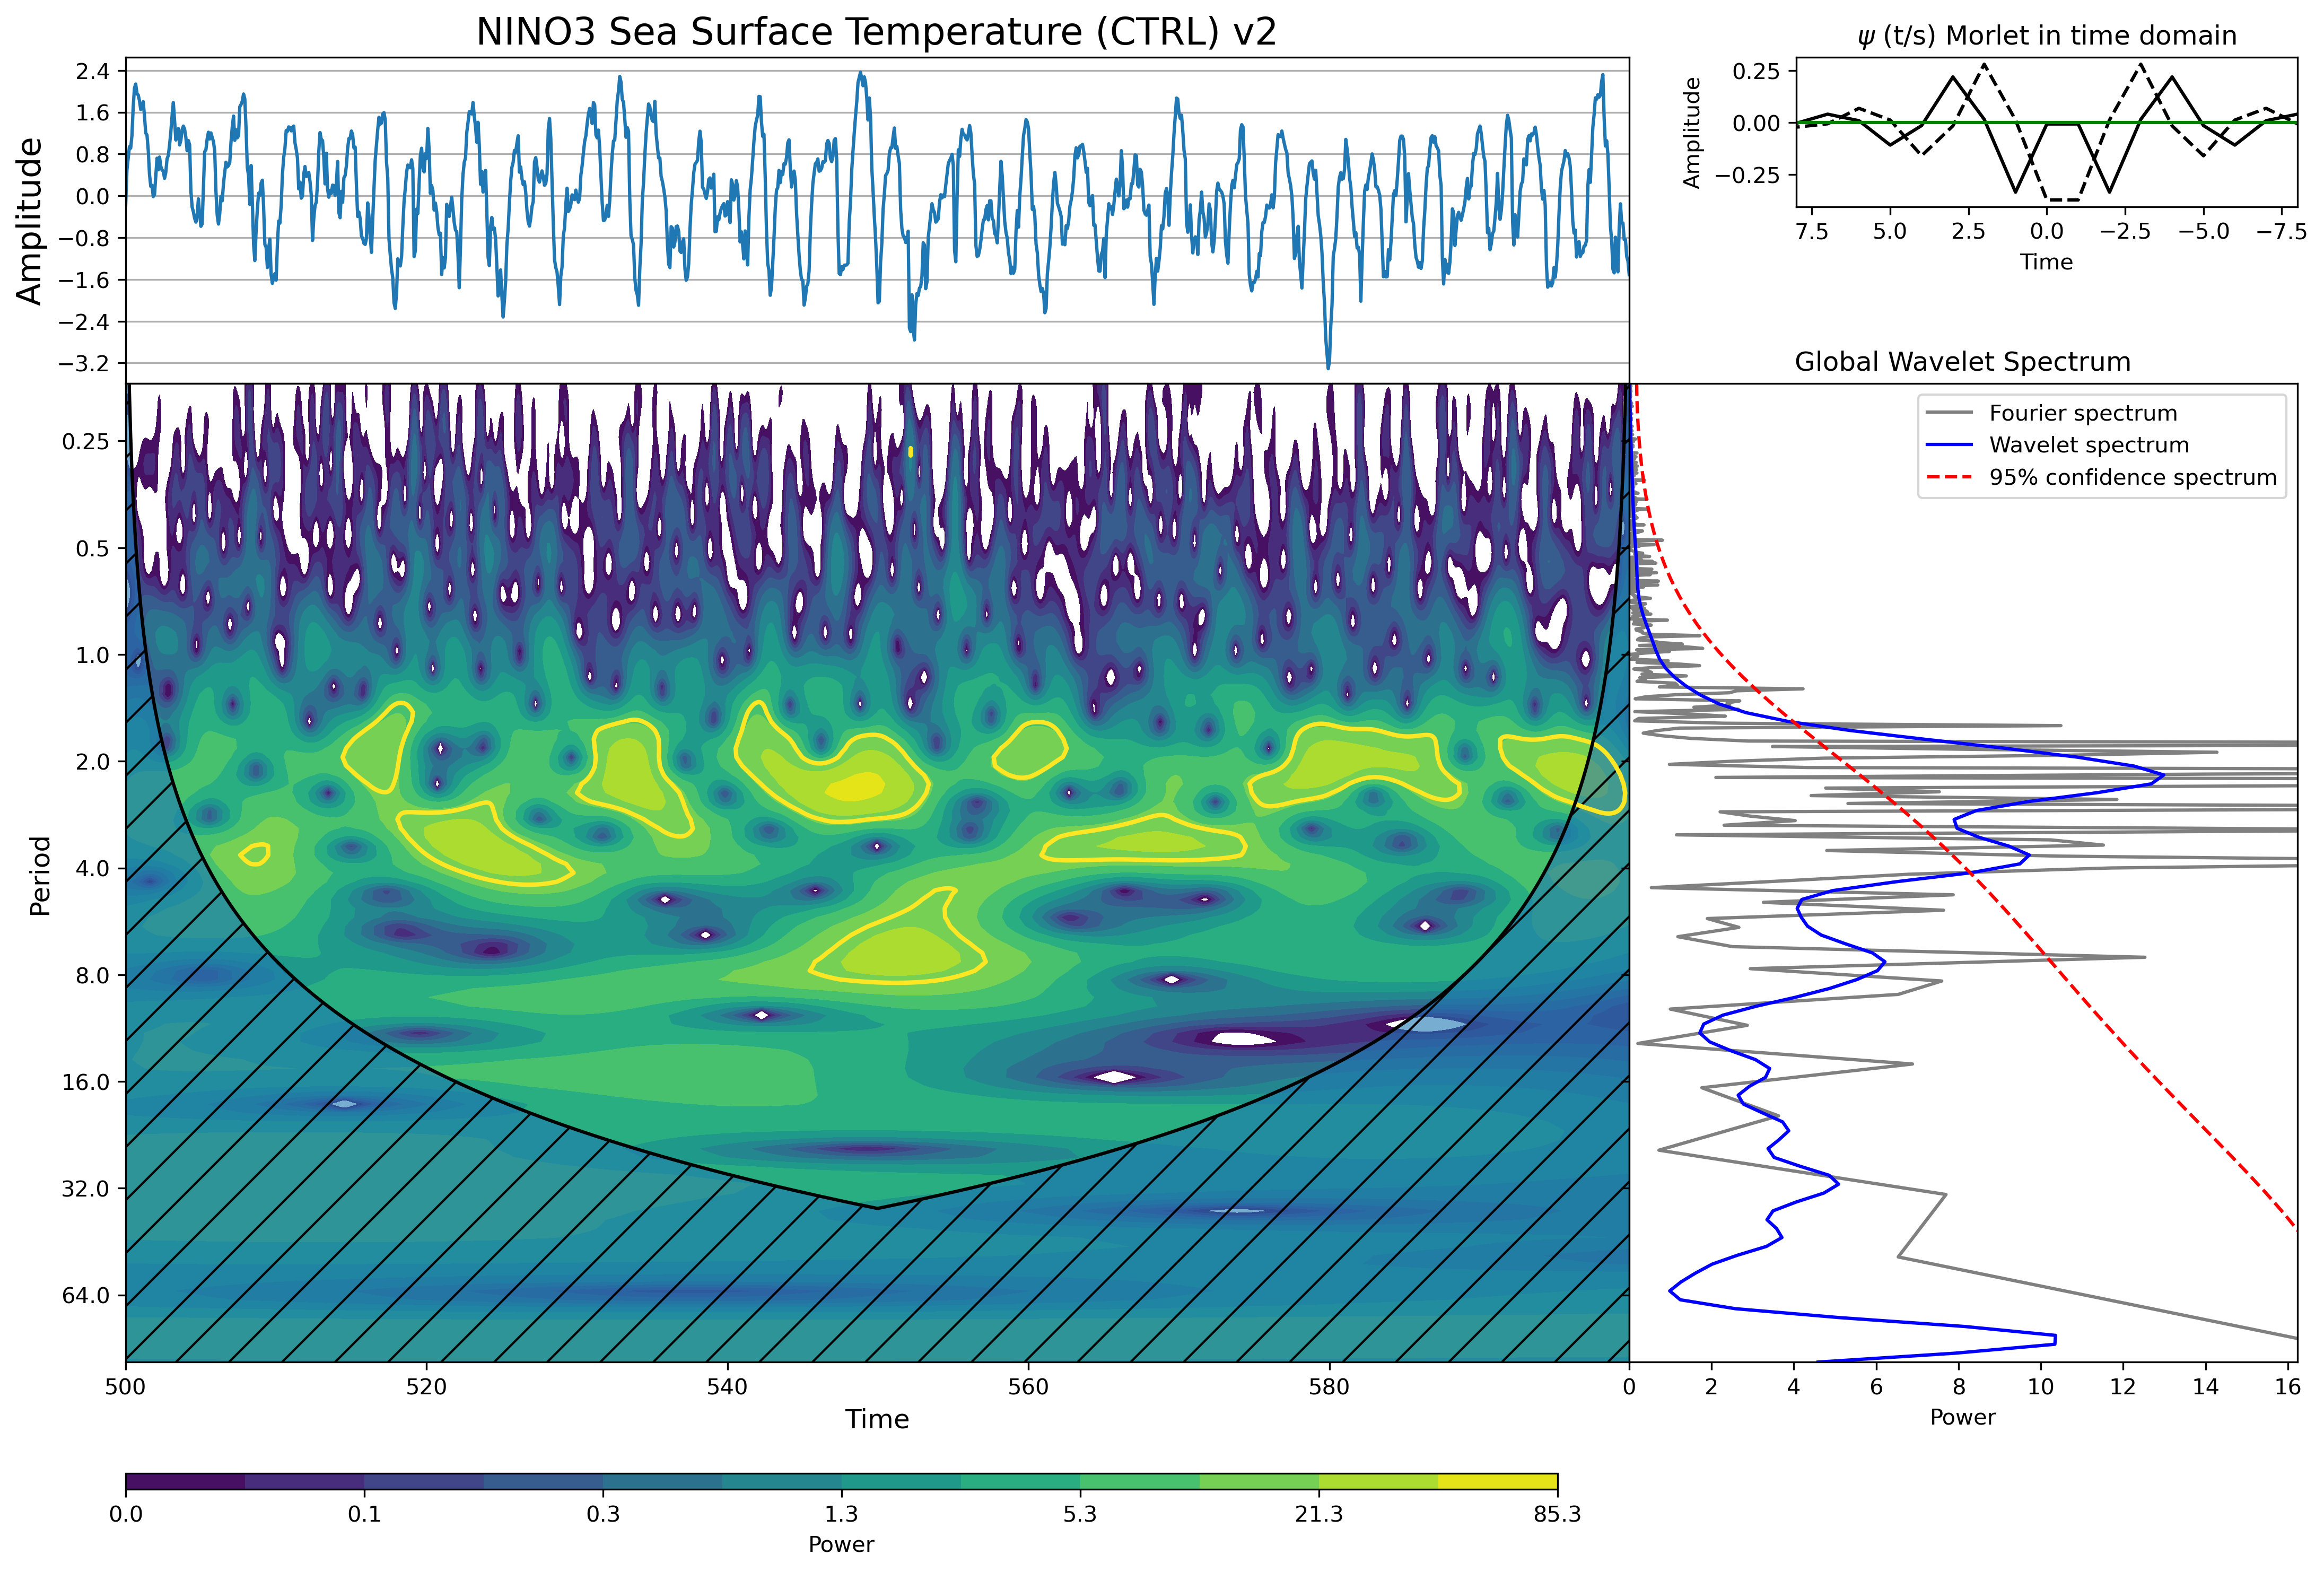

In [4]:
var='NINO3 Sea Surface Temperature (CTRL) v2'
dtmin = dt/8    # dt/n of suboctaves
waipy.wavelet_plot(var, n3_time_frac, data_norm, dtmin, result)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


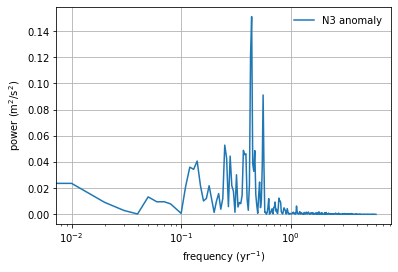

In [5]:
'''
FFT
'''
from scipy import signal

# time in 1 month
time_months = (n3_time_frac-np.min(n3_time_frac) ) * 12
print(time_months[0:13])

# welch and with a cat hat something.... for the signal leaking
# use the whole 6 hourly data windows
f, PUU = signal.welch(n3_anomaly,12/np.diff(time_months)[0],nperseg=len(n3_time_frac),scaling='spectrum')

plt.plot(f, PUU,label='N3 anomaly')
#plt.plot(f_smooth, PUU_smooth,label='smooth')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('frequency (yr$^{-1}$)')
plt.ylabel('power (m$^2$/s$^2$)')
plt.legend(frameon=False)
plt.grid()

# CTRL and RP2 PD industrial

In [15]:
# --- read data ---
idir = '/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
t1Name = 'r1i1p2f1/Amon/ts/gn/v20230616/ts_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_0[56]*.nc'
t_in = xr.open_mfdataset(idir+t1Name, combine='by_coords')
year_start = 500
year_end = 649
t_ds = t_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144

# Calculate the Nino3 index
n3 = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])
# Calculate time in fraction of years
n3_time_frac = (n3.time.dt.year + (n3.time.dt.month - 1)/12).values
# Calculate climatology of SST over Nino3 region
sst_climatology = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month').mean(dim='time')
# Compute anomaly
sst_anomaly = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month') - sst_climatology
# Calculate the Nino3 anomaly index
n3_anomaly = sst_anomaly.mean(dim=['lon', 'lat']) # .mean('month')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]


In [16]:
""" OPEN ARCHIVE .TXT/.DAT
    archive = file.txt
    dt      = data sampling
    date1   = data initial time"
    https://github.com/chris-torrence/wavelets/tree/main/wave_idl
"""
N =len(n3_anomaly)      # the time series of length N.

dt = 1/12    # amount of time between each time series value, i.e. the sampling time.
            # seasonal data 1/4 year - 4 measures in 1 year

T1 = 1850.  # start time

n3_anomaly[np.isnan(n3_anomaly)] = 0  # replace nan to zero
data_norm = waipy.normalize(n3_anomaly).values

In [17]:
pad = 1         # pad the time series with zeroes (recommended)
dj = 1/12.       # this will do 4 sub-octaves per octave
s0 = 2*dt       # this says start at a scale of 6 months if dt =annual
j1 = 7/dj       # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72     # lag-1 autocorrelation for red noise background
param = 6
mother = 'Morlet'
dt = 1/12.

result = waipy.cwt(data_norm, dt, pad, dj, s0, j1, lag1, param, mother='Morlet',name='Nino3')

Nr of Scales: 117
scales [0.16666666666666666, 0.17657718239321588, 0.18707700805156216, 0.19820118583378682, 0.20998684164914552, 0.22247330902833906, 0.23570226039551584, 0.2497178461461136, 0.2645668419946999, 0.2802988050845715, 0.2969662393801131, 0.3146247708938978, 0.3333333333333333, 0.35315436478643175, 0.37415401610312427, 0.39640237166757364, 0.41997368329829105, 0.444946618056678, 0.4714045207910317, 0.4994356922922272, 0.5291336839893998, 0.560597610169143, 0.5939324787602261, 0.6292495417877956, 0.6666666666666666, 0.7063087295728634, 0.7483080322062485, 0.7928047433351473, 0.839947366596582, 0.889893236113356, 0.9428090415820634, 0.9988713845844541, 1.0582673679787995, 1.121195220338286, 1.187864957520452, 1.2584990835755911, 1.3333333333333333, 1.4126174591457268, 1.496616064412497, 1.5856094866702946, 1.679894733193164, 1.779786472226712, 1.8856180831641267, 1.9977427691689083, 2.116534735957599, 2.242390440676572, 2.375729915040904, 2.5169981671511823, 2.6666666666666

{'fig': <Figure size 4500x3000 with 5 Axes>,
 'ax_data': <AxesSubplot:title={'center':'NINO3 Sea Surface Temperature (CTRL) v3'}, ylabel='Amplitude'>,
 'ax_cwt': <AxesSubplot:xlabel='Time', ylabel='Period'>,
 'ax_wavelet': <AxesSubplot:title={'center':'$\\psi$ (t/s) Morlet in time domain'}, xlabel='Time', ylabel='Amplitude'>,
 'ax_global_spectrum': <AxesSubplot:title={'center':'Global Wavelet Spectrum'}, xlabel='Power'>}

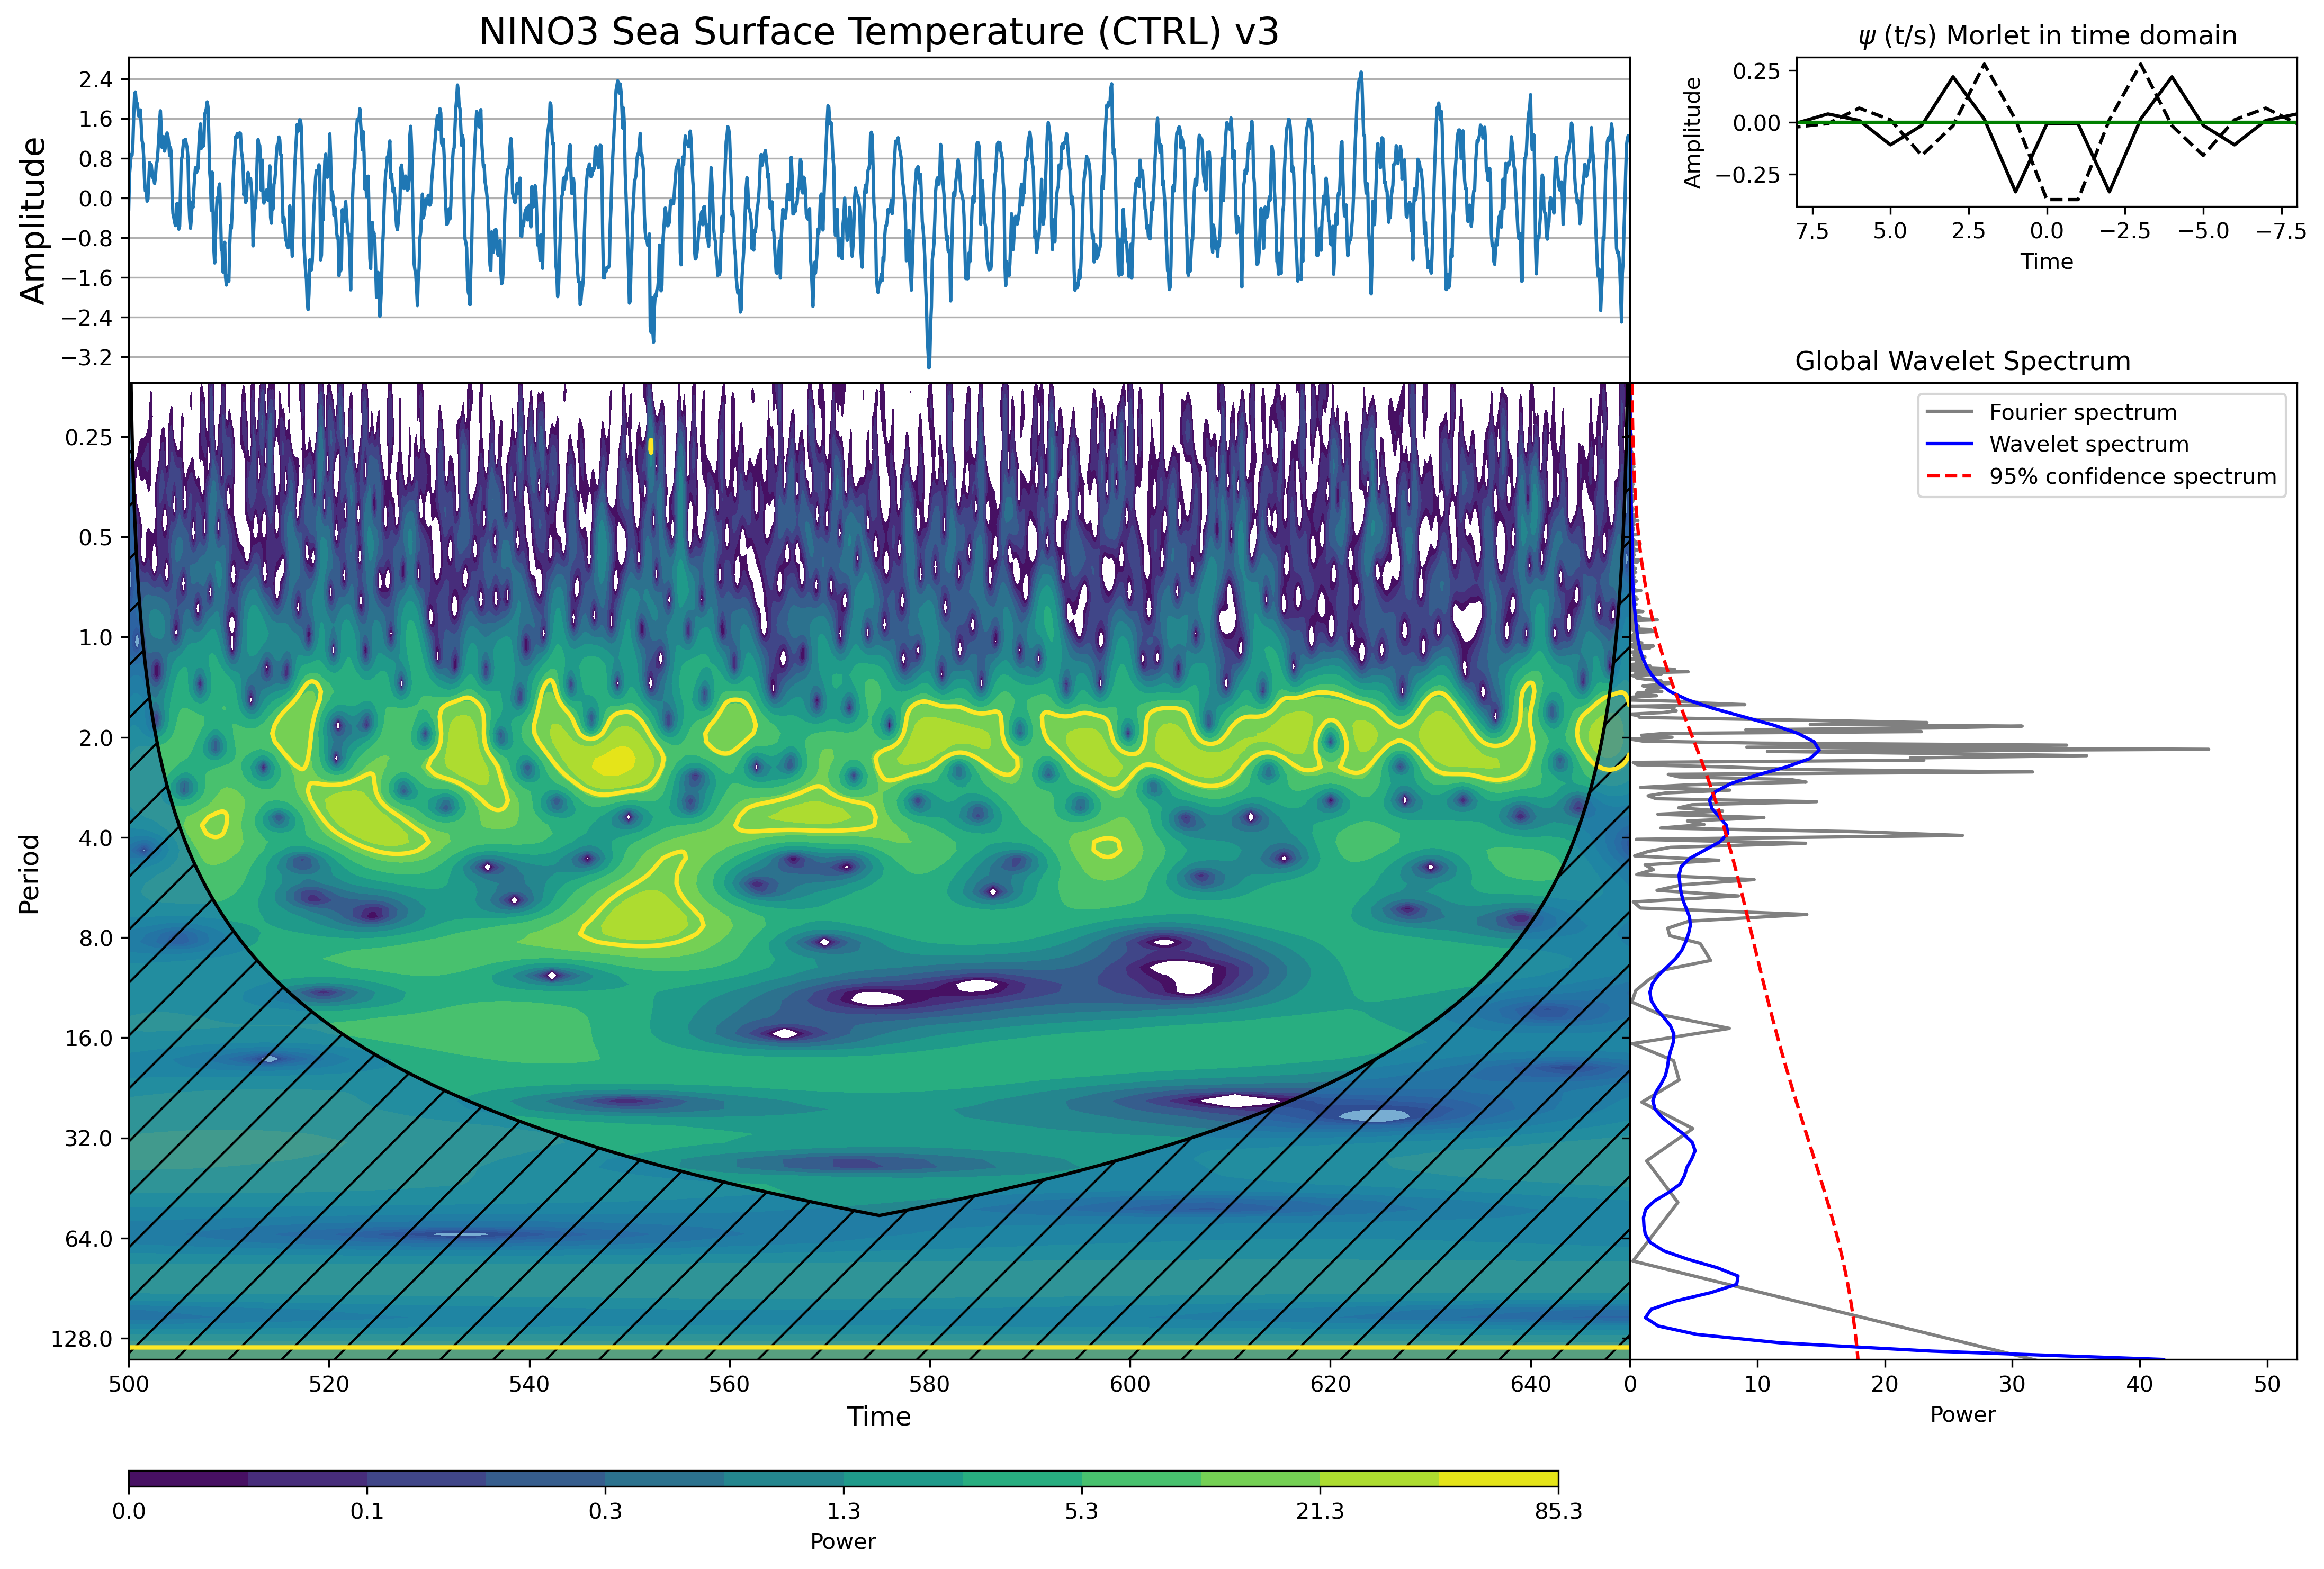

In [18]:
var='NINO3 Sea Surface Temperature (CTRL) v3'
dtmin = dt/8    # dt/n of suboctaves
waipy.wavelet_plot(var, n3_time_frac, data_norm, dtmin, result)

# RP2

In [11]:
# --- read data ---
idir = '/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
t1Name = 'r1i1p3f1/Amon/ts/gn/v20230517/ts_Amon_ACCESS-CM2_piControl_r1i1p3f1_gn_0[56]*.nc'
t_in = xr.open_mfdataset(idir+t1Name, combine='by_coords')
#t_in = xr.open_dataset(idir+t1Name)
year_start = 500
year_end = 649
t_ds = t_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144

# Calculate the Nino3 index
n3 = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])
# Calculate time in fraction of years
n3_time_frac = (n3.time.dt.year + (n3.time.dt.month - 1)/12).values
# Calculate climatology of SST over Nino3 region
sst_climatology = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month').mean(dim='time')
# Compute anomaly
sst_anomaly = t_ds['ts'].sel(lon=slice(210, 270), lat=slice(-5, 5)).groupby('time.month') - sst_climatology
# Calculate the Nino3 anomaly index
n3_anomaly = sst_anomaly.mean(dim=['lon', 'lat']) # .mean('month')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 75 times more chunks
  return self.array[key]


In [12]:
""" OPEN ARCHIVE .TXT/.DAT
    archive = file.txt
    dt      = data sampling
    date1   = data initial time"
    https://github.com/chris-torrence/wavelets/tree/main/wave_idl
"""
N =len(n3_anomaly)      # the time series of length N.

dt = 1/12    # amount of time between each time series value, i.e. the sampling time.
            # seasonal data 1/4 year - 4 measures in 1 year

T1 = 1850.  # start time

n3_anomaly[np.isnan(n3_anomaly)] = 0  # replace nan to zero
data_norm = waipy.normalize(n3_anomaly).values

In [13]:
pad = 1         # pad the time series with zeroes (recommended)
dj = 1/12.       # this will do 4 sub-octaves per octave
s0 = 2*dt       # this says start at a scale of 6 months if dt =annual
j1 = 7/dj       # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72     # lag-1 autocorrelation for red noise background
param = 6
mother = 'Morlet'
dt = 1/12.

result = waipy.cwt(data_norm, dt, pad, dj, s0, j1, lag1, param, mother='Morlet',name='Nino3')

Nr of Scales: 117
scales [0.16666666666666666, 0.17657718239321588, 0.18707700805156216, 0.19820118583378682, 0.20998684164914552, 0.22247330902833906, 0.23570226039551584, 0.2497178461461136, 0.2645668419946999, 0.2802988050845715, 0.2969662393801131, 0.3146247708938978, 0.3333333333333333, 0.35315436478643175, 0.37415401610312427, 0.39640237166757364, 0.41997368329829105, 0.444946618056678, 0.4714045207910317, 0.4994356922922272, 0.5291336839893998, 0.560597610169143, 0.5939324787602261, 0.6292495417877956, 0.6666666666666666, 0.7063087295728634, 0.7483080322062485, 0.7928047433351473, 0.839947366596582, 0.889893236113356, 0.9428090415820634, 0.9988713845844541, 1.0582673679787995, 1.121195220338286, 1.187864957520452, 1.2584990835755911, 1.3333333333333333, 1.4126174591457268, 1.496616064412497, 1.5856094866702946, 1.679894733193164, 1.779786472226712, 1.8856180831641267, 1.9977427691689083, 2.116534735957599, 2.242390440676572, 2.375729915040904, 2.5169981671511823, 2.6666666666666

{'fig': <Figure size 4500x3000 with 5 Axes>,
 'ax_data': <AxesSubplot:title={'center':'NINO3 Sea Surface Temperature (CTRL) v3 with RP2'}, ylabel='Amplitude'>,
 'ax_cwt': <AxesSubplot:xlabel='Time', ylabel='Period'>,
 'ax_wavelet': <AxesSubplot:title={'center':'$\\psi$ (t/s) Morlet in time domain'}, xlabel='Time', ylabel='Amplitude'>,
 'ax_global_spectrum': <AxesSubplot:title={'center':'Global Wavelet Spectrum'}, xlabel='Power'>}

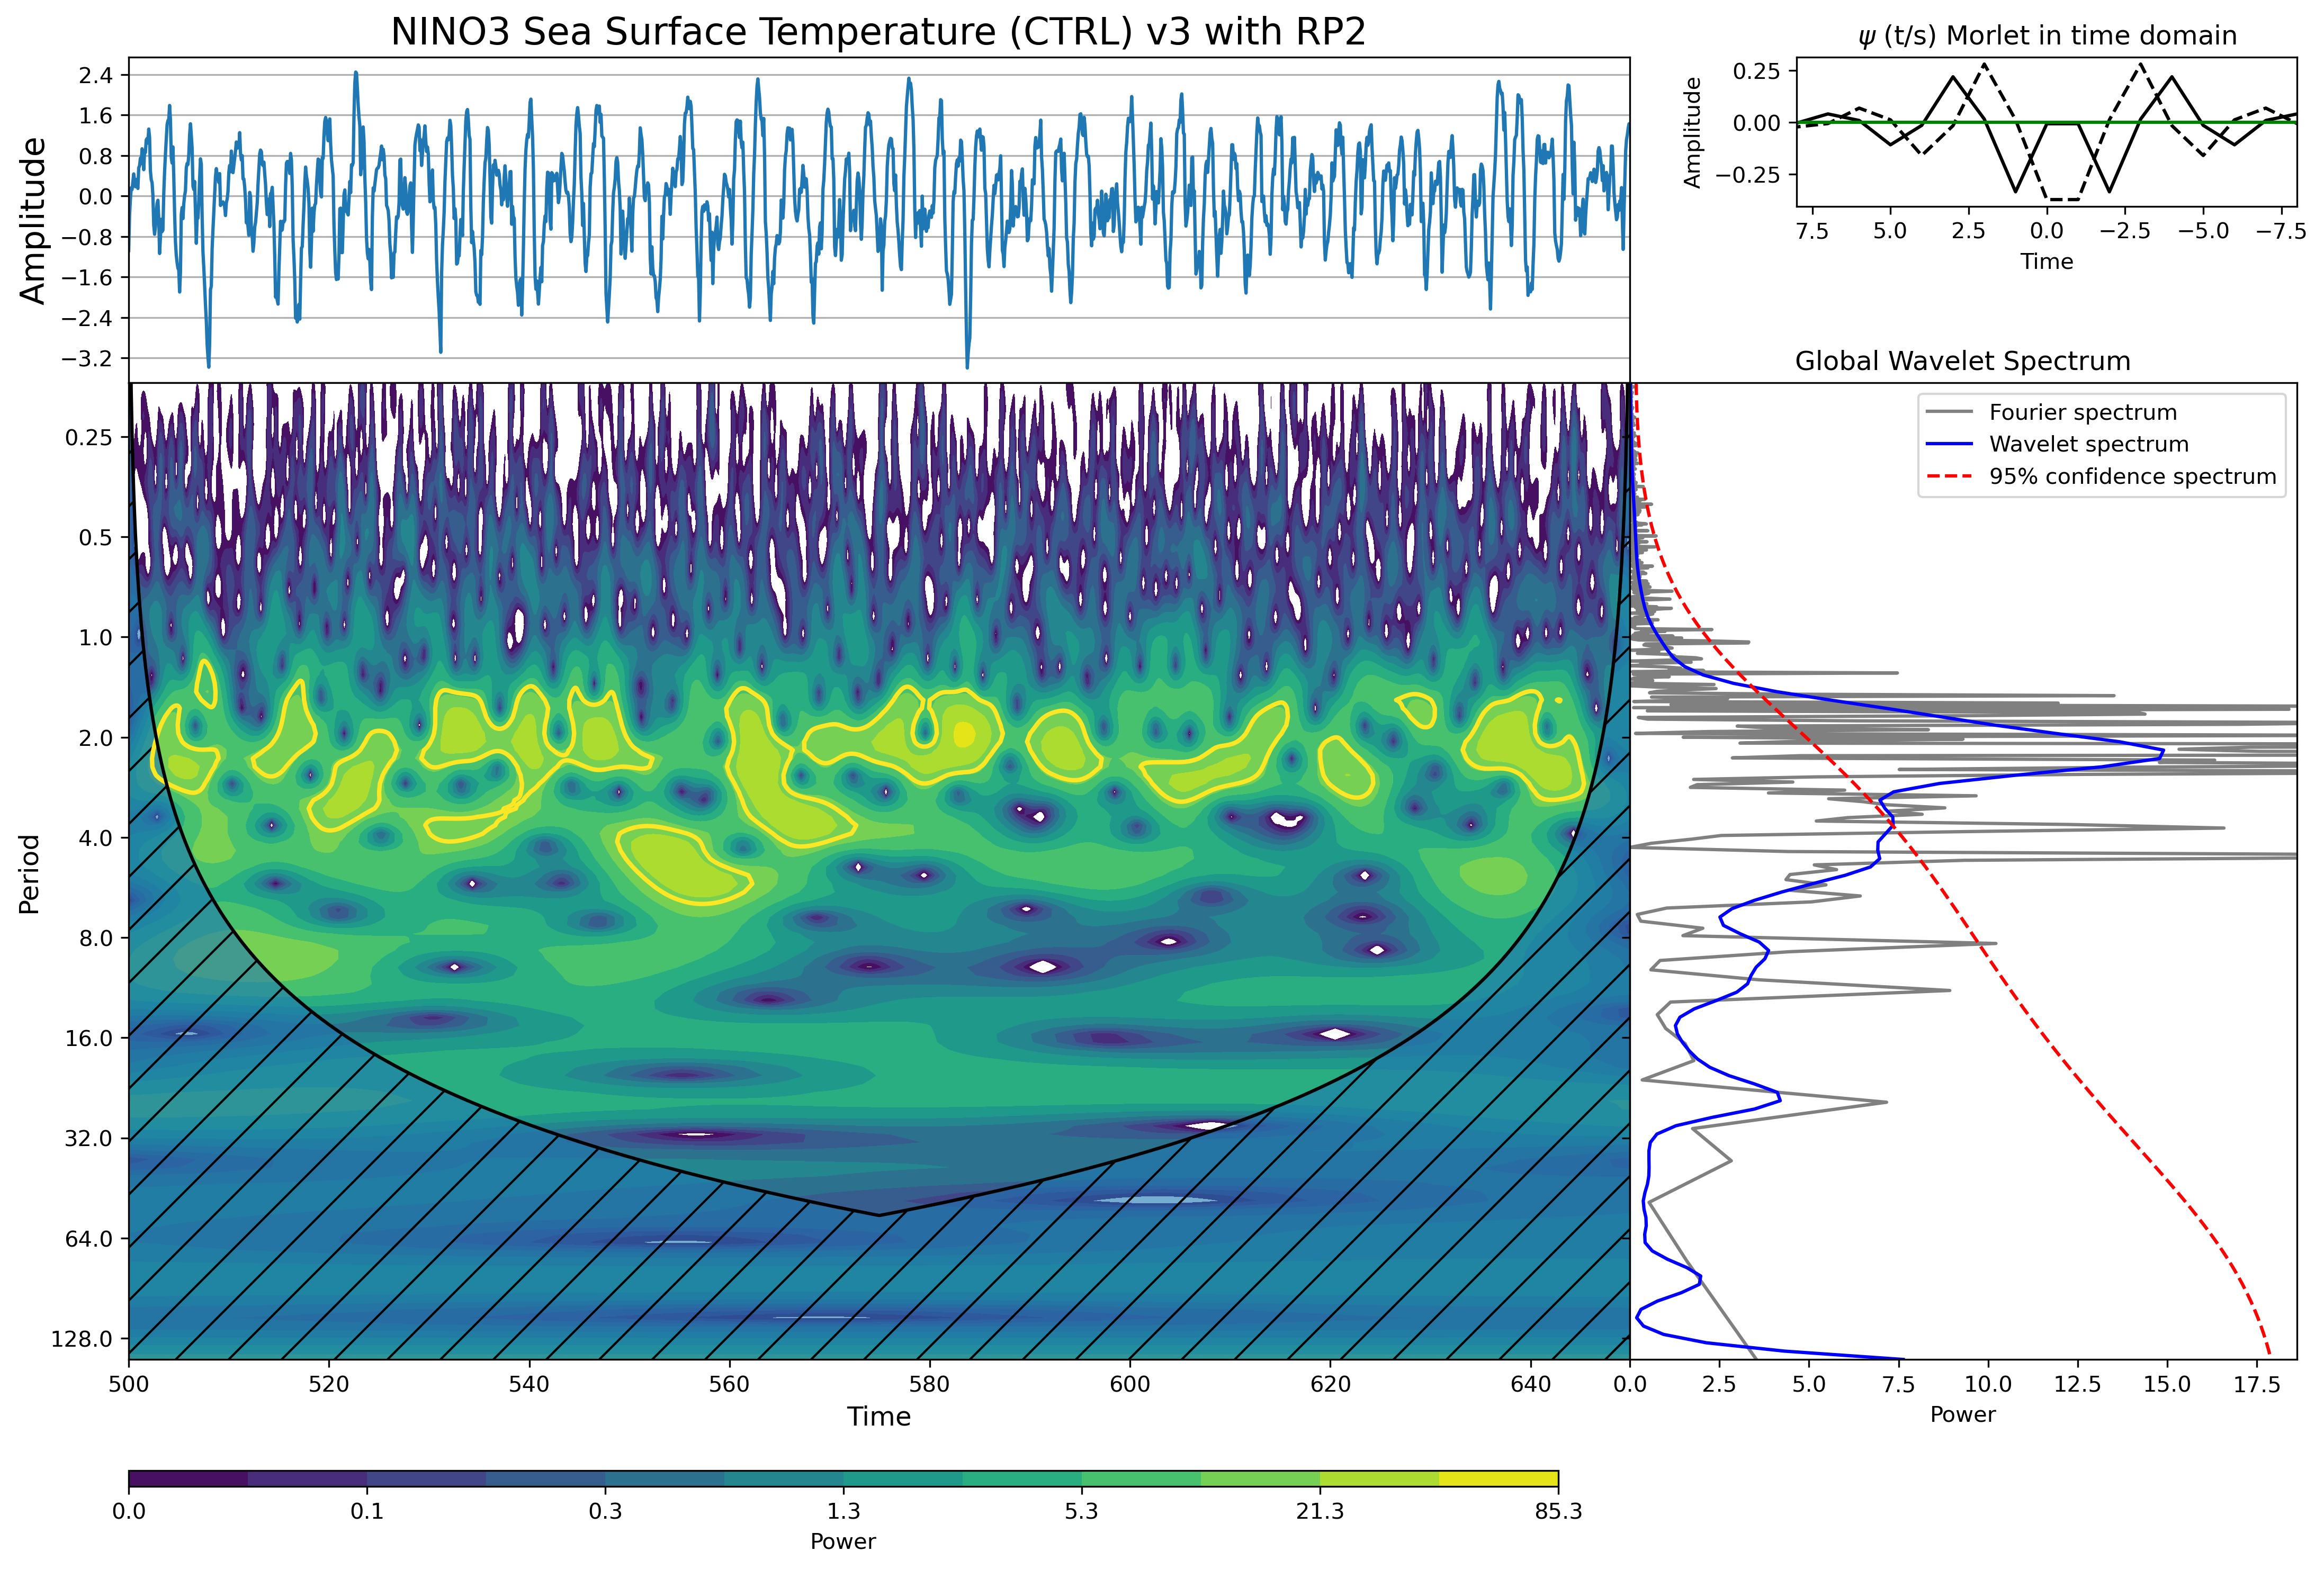

In [14]:
var='NINO3 Sea Surface Temperature (CTRL) v3 with RP2'
dtmin = dt/8    # dt/n of suboctaves
waipy.wavelet_plot(var, n3_time_frac, data_norm, dtmin, result)